In [13]:
# Step 1: Load and Preprocess the Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

# Convert Google Drive link to direct download link
file_id = '1ClsvVfGvk8fJLtd_ZmLDDnl5uBzF0j9D'
url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Load data
try:
    df = pd.read_csv(url)
except Exception as e:
    raise FileNotFoundError(f"Error loading data from {url}: {str(e)}")
print("Original dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nDataset head:\n", df.head())

# Filter to African countries (region_id: SSF for Sub-Saharan Africa, MEA for Middle East & North Africa)
african_regions = ['SSF', 'MEA']
df_africa = df[df['region_id'].isin(african_regions)].copy()  # Avoid SettingWithCopyWarning
print("African dataset shape:", df_africa.shape)

# Identify numeric and categorical columns
numeric_cols = df_africa.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_africa.select_dtypes(include=['object']).columns
print("Numeric columns (count: {}): {}".format(len(numeric_cols), numeric_cols.tolist()))
print("Categorical columns (count: {}): {}".format(len(categorical_cols), categorical_cols.tolist()))

# Drop numeric columns with all NaN values before imputation
all_nan_cols = df_africa[numeric_cols].columns[df_africa[numeric_cols].isna().all()]
if len(all_nan_cols) > 0:
    print("Warning: Dropping numeric columns with all NaN values:", all_nan_cols.tolist())
    df_africa = df_africa.drop(columns=all_nan_cols)
    numeric_cols = numeric_cols.difference(all_nan_cols)
print("Dataset shape after dropping all-NaN numeric columns:", df_africa.shape)

# Impute missing values
# Numeric: Mean imputation
imputer_num = SimpleImputer(strategy='mean')
df_africa[numeric_cols] = imputer_num.fit_transform(df_africa[numeric_cols])

# Categorical: Mode imputation
imputer_cat = SimpleImputer(strategy='most_frequent')
df_africa[categorical_cols] = imputer_cat.fit_transform(df_africa[categorical_cols])
print("After imputation, missing values:", df_africa.isnull().sum().sum())

# Encode categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
encoded_cats = encoder.fit_transform(df_africa[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)
df_encoded = pd.DataFrame(encoded_cats, columns=encoded_cols, index=df_africa.index)

# Combine numeric and encoded categorical columns
df_processed = pd.concat([df_africa[numeric_cols], df_encoded], axis=1)
print("Processed dataset shape:", df_processed.shape)

# Drop columns with zero standard deviation
stds = df_processed.std()
cols_to_drop = stds[stds == 0].index
if len(cols_to_drop) > 0:
    print("Warning: Dropping columns with zero standard deviation:", cols_to_drop.tolist())
    df_processed = df_processed.drop(cols_to_drop, axis=1)
print("Final cleaned dataset shape:", df_processed.shape)
print("Remaining columns:", df_processed.columns.tolist())

# Check for sufficient columns
if df_processed.shape[1] < 10:
    raise ValueError("Dataset has fewer than 10 columns after cleaning.")

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_processed)
print("Standardized data shape:", X_scaled.shape)
print("Standardized data sample (first 5 rows):\n", X_scaled[:5])

Original dataset shape: (217, 51)
Columns: ['iso3c', 'region_id', 'country_name', 'income_id', 'gdp', 'composition_food_organic_waste_percent', 'composition_glass_percent', 'composition_metal_percent', 'composition_other_percent', 'composition_paper_cardboard_percent', 'composition_plastic_percent', 'composition_rubber_leather_percent', 'composition_wood_percent', 'composition_yard_garden_green_waste_percent', 'other_information_information_system_for_solid_waste_management', 'other_information_national_agency_to_enforce_solid_waste_laws_and_regulations', 'other_information_national_law_governing_solid_waste_management_in_the_country', 'other_information_ppp_rules_and_regulations', 'other_information_summary_of_key_solid_waste_information_made_available_to_the_public', 'population_population_number_of_people', 'special_waste_agricultural_waste_tons_year', 'special_waste_construction_and_demolition_waste_tons_year', 'special_waste_e_waste_tons_year', 'special_waste_hazardous_waste_tons_

In [6]:
# Step 2: Apply PCA
from mypca import MyPCA
# Initialize and fit PCA
pca = MyPCA()
pca.fit(X_scaled)
n_components = pca.choose_n_components(threshold=0.95)
print(f"Number of components to retain 95% variance: {n_components}")

# Transform data
X_pca = pca.transform(X_scaled)
print("Transformed data shape:", X_pca.shape)

# Print explained variance ratios
print("Explained variance ratios:", pca.explained_variance_ratio_[:n_components])
print("Cumulative variance:", np.cumsum(pca.explained_variance_ratio_)[:n_components])

Number of components to retain 95% variance: 63
Transformed data shape: (69, 69)
Explained variance ratios: [0.04968497 0.03951919 0.02890012 0.02748714 0.02494488 0.02444412
 0.02310926 0.02194855 0.02132523 0.02052825 0.01953687 0.01905366
 0.01831582 0.01751984 0.0171575  0.01665344 0.01577711 0.01521823
 0.01490662 0.0147208  0.01457159 0.01384319 0.01376736 0.0132452
 0.01303659 0.01302022 0.012637   0.01230183 0.01226885 0.01205425
 0.01183386 0.01181976 0.01162772 0.01148387 0.01142115 0.01140471
 0.01135533 0.01129483 0.01117805 0.01114014 0.01113599 0.0111248
 0.0110905  0.01107508 0.0110598  0.01104584 0.01103506 0.01103227
 0.01102941 0.01102941 0.01102941 0.01102941 0.01102941 0.01102941
 0.01102941 0.01102941 0.01102941 0.01102941 0.01102941 0.01102941
 0.01102941 0.01102941 0.01102941]
Cumulative variance: [0.04968497 0.08920416 0.11810427 0.14559142 0.17053629 0.19498041
 0.21808968 0.24003823 0.26136346 0.28189171 0.30142858 0.32048224
 0.33879806 0.3563179  0.3734754  

In [15]:
# Download mypca.py from Google Drive
import requests

file_id = '1juT_sMsQw34NOYVUAmMs2oFAyH7uF4lf'
url = f'https://drive.google.com/uc?export=download&id={file_id}'
filename = 'mypca.py'

try:
    response = requests.get(url)
    response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded {filename}")
except requests.exceptions.RequestException as e:
    print(f"Error downloading {filename}: {e}")

# Import the MyPCA class
from mypca import MyPCA

Downloaded mypca.py


**Note:** The `mypca.py` file is downloaded to the Colab environment, which is temporary. This means the file will be removed when the Colab runtime ends.

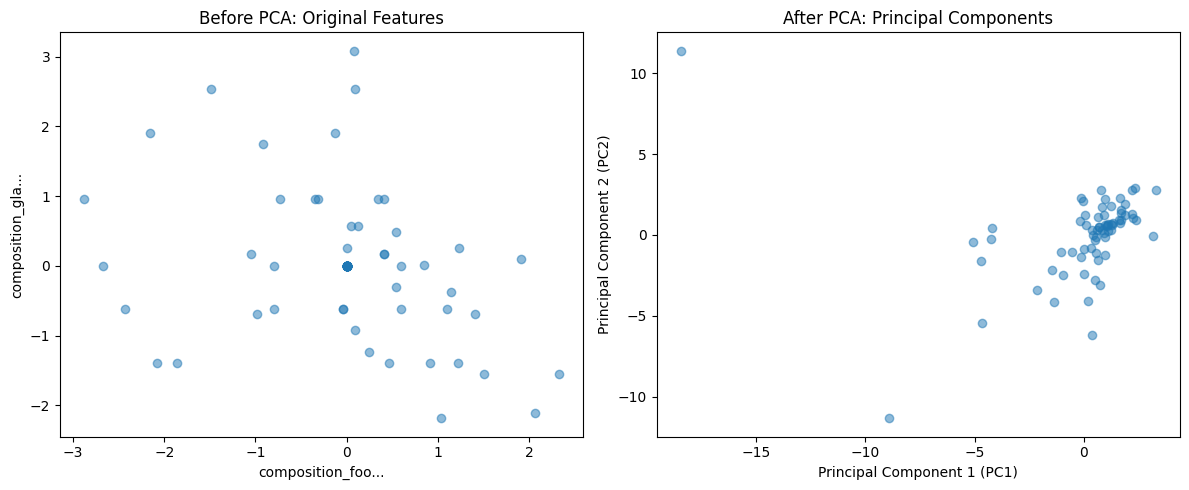

In [16]:
# Step 3: Visualize Before and After PCA
plt.figure(figsize=(12, 5))

# Before PCA: Plot two numeric features
plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], alpha=0.5)
plt.xlabel(numeric_cols[0][:15] + '...' if len(numeric_cols[0]) > 15 else numeric_cols[0])
plt.ylabel(numeric_cols[1][:15] + '...' if len(numeric_cols[1]) > 15 else numeric_cols[1])
plt.title("Before PCA: Original Features")

# After PCA: Plot PC1 vs PC2
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.title("After PCA: Principal Components")
plt.tight_layout()
plt.show()

In [17]:
# Step 4: Optimize PCA for Large Datasets
from timeit import default_timer as timer

def pca_eig(X):
    cov = np.cov(X.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    return eigenvalues, eigenvectors

def pca_svd(X):
    U, S, Vh = np.linalg.svd(X, full_matrices=False)
    return S**2 / (X.shape[0] - 1), Vh.T

# Time on current data
start = timer()
pca_eig(X_scaled)
end = timer()
print("Eig time:", end - start)

start = timer()
pca_svd(X_scaled)
end = timer()
print("SVD time:", end - start)

# Test on large synthetic dataset
large_X = np.random.rand(10000, 50)
start = timer()
pca_eig(large_X)
end = timer()
print("Eig time on large data:", end - start)

start = timer()
pca_svd(large_X)
end = timer()
print("SVD time on large data:", end - start)

# Explained variance from SVD
U, S, Vh = np.linalg.svd(X_scaled, full_matrices=False)
svd_eigenvalues = S**2 / (X_scaled.shape[0] - 1)
print("Explained variance from SVD:", svd_eigenvalues / np.sum(svd_eigenvalues))

Eig time: 0.018471500000032393
SVD time: 0.0018780999998853076
Eig time on large data: 0.007648750000043947
SVD time on large data: 0.044784616000015376
Explained variance from SVD: [4.96849655e-02 3.95191898e-02 2.89001162e-02 2.74871444e-02
 2.49448782e-02 2.44441191e-02 2.31092633e-02 2.19485506e-02
 2.13252336e-02 2.05282533e-02 1.95368690e-02 1.90536590e-02
 1.83158200e-02 1.75198378e-02 1.71574988e-02 1.66534437e-02
 1.57771095e-02 1.52182343e-02 1.49066245e-02 1.47208027e-02
 1.45715923e-02 1.38431861e-02 1.37673593e-02 1.32452031e-02
 1.30365885e-02 1.30202233e-02 1.26370004e-02 1.23018306e-02
 1.22688481e-02 1.20542463e-02 1.18338561e-02 1.18197557e-02
 1.16277169e-02 1.14838661e-02 1.14211486e-02 1.14047132e-02
 1.13553258e-02 1.12948255e-02 1.11780458e-02 1.11401353e-02
 1.11359928e-02 1.11247969e-02 1.10905008e-02 1.10750812e-02
 1.10598026e-02 1.10458432e-02 1.10350575e-02 1.10322680e-02
 1.10294118e-02 1.10294118e-02 1.10294118e-02 1.10294118e-02
 1.10294118e-02 1.1029411

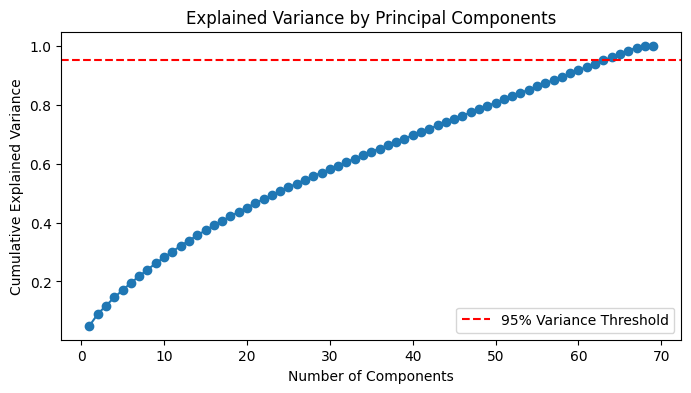

In [18]:
# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.show()